In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import xgboost as xgb

In [2]:
df = pd.read_csv('data/taiwan_bankruptcy_data.csv')

In [3]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,tax Pre-net interest rate,after-tax net interest rate,non-industry income and expenditure/revenue,...,net income to total assets,total assets to GNP price,No-credit interval,Gross profit to Sales,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [4]:
f = np.array(df.isna().sum())

In [5]:
# no nans lit
f

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [6]:
test = df.corr().abs().stack().reset_index().sort_values(0,ascending=False)
test['pairs'] = list(zip(test.level_0,test.level_1))
test.set_index(['pairs'], inplace=True)
test.drop(columns=['level_1','level_0'], inplace=True)
test.columns = ['cc']
test.drop_duplicates(inplace=True)


In [7]:
test.sort_values('cc',ascending=False, inplace=True)
multicollinear_predictors = test[test.cc >.75]
multicollinear_predictors.reset_index(inplace=True)

In [8]:
multicollinear_predictors['column_1'] = multicollinear_predictors.pairs.map(lambda x : x[0])
multicollinear_predictors['column_2'] = multicollinear_predictors.pairs.map(lambda x : x[1])

<ipython-input-8-a30768636eb9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multicollinear_predictors['column_1'] = multicollinear_predictors.pairs.map(lambda x : x[0])
<ipython-input-8-a30768636eb9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  multicollinear_predictors['column_2'] = multicollinear_predictors.pairs.map(lambda x : x[1])


In [9]:
multicollinear_predictors

,pairs,cc,column_1,column_2
0,"( net worth/assets, debt ratio %)",1.000000,net worth/assets,debt ratio %
1,"( regular net profit growth rate, regular net...",1.000000,regular net profit growth rate,regular net profit growth rate
2,"(Gross profit to Sales, operating gross margin)",1.000000,Gross profit to Sales,operating gross margin
3,"( Net Value Per Share (C), Net Value Per Shar...",0.999837,Net Value Per Share (C),Net Value Per Share (A)
4,"( operating gross margin, realized sales gros...",0.999518,operating gross margin,realized sales gross margin
5,"( realized sales gross margin, Gross profit to...",0.999518,realized sales gross margin,Gross profit to Sales
6,"( Net Value Per Share (A), per Net Share Valu...",0.999342,Net Value Per Share (A),per Net Share Value (B)
7,"( per Net Share Value (B), Net Value Per Shar...",0.999179,per Net Share Value (B),Net Value Per Share (C)
8,"( Operating profit/paid-in capital, Operating...",0.998696,Operating profit/paid-in capital,Operating Profit Per Share (Yuan)
9,"( regular net profit growth rate, after-tax n...",0.996186,regular net profit growth rate,after-tax net profit growth rate


In [10]:
columns_to_drop = [' net worth/assets','Gross profit to Sales',' Net Value Per Share (A)',' per Net Share Value (B)',
                  ' realized sales gross margin',' Operating profit/paid-in capital',' regular net profit growth rate',
                  ' continuous interest rate (after tax)',' ROA(A) before interest and % after tax',' ROA(B) before interest and depreciation after tax',
                  ' tax Pre-net interest rate',' net profit before tax/paid-in capital',
                  ' borrowing dependency',' Per Share Net profit before tax (yuan)',
                  'liability to equity',' Cash flow to Sales','operating funds to liability',' Operating Profit Per Share (Yuan)',
                  ' after-tax net interest rate','one if net income was negative for the last two year zero otherwise']

In [11]:
test2 = df.drop(columns=columns_to_drop,axis=1)

In [12]:
test3 = test2.corr().abs().stack().reset_index().sort_values(0,ascending=False)
test3['pairs'] = list(zip(test3.level_0,test3.level_1))
test3.set_index(['pairs'], inplace=True)
test3.drop(columns=['level_1','level_0'], inplace=True)
test3.columns = ['cc']
test3.drop_duplicates(inplace=True)

test3[test3.cc >.75]


,cc
pairs,
"(Bankrupt?, Bankrupt?)",1.000000
"( ROA(C) before interest and depreciation before interest, net income to total assets)",0.887670
"( debt ratio %, current liability to assets)",0.842583
"(Retained Earnings/Total assets, net income to total assets)",0.794189
"( Persistent EPS in the Last Four Seasons, ROA(C) before interest and depreciation before interest)",0.775006
"(working capital/equity, contingent liabilities/net worth)",0.767778
"( total asset turnover, net worth turnover rate (times))",0.757414
"(current assets/total assets, Quick asset/Total asset)",0.755453
"( Net Value Per Share (C), Persistent EPS in the Last Four Seasons)",0.755217


In [13]:
#dropping columns that have high corr for multicollinearity

df2 = df.drop(columns=columns_to_drop,axis=1)

In [14]:
# all data types are float64s lit
# could check unique values but will investigate after

df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 76 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Bankrupt?                                                     6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest      6819 non-null   float64
 2    operating gross margin                                       6819 non-null   float64
 3    operating profit rate                                        6819 non-null   float64
 4    non-industry income and expenditure/revenue                  6819 non-null   float64
 5    operating expense rate                                       6819 non-null   float64
 6    research and development expense rate                        6819 non-null   float64
 7    cash flow rate                                               6819 no

Columns I predict will be significant predictors

35   interest expense ratio

14 interest-bearing debt interest rate

36   total debt/total net worth

67  long-term liability to current assets

81  cash flow to liability 

84  current liabilities to current assets

92  Degree of financial leverage (DFL)

In [15]:
X = df2.drop(columns='Bankrupt?',axis=1)
y = df2['Bankrupt?']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=.25)
logreg = LogisticRegression(fit_intercept=True, C=1e12, solver='liblinear')

In [16]:
def sigmoid(x):
    x = np.array(x)
    return 1/(1 + np.e**(-1*x))

In [61]:
base = logreg.fit(X_train,y_train)
y_hat_base = base.predict(X_test)
print(base)
base_yscore = base.decision_function(X_test)

fpr, tpr, thresholds = roc_curve(y_test, base_yscore)
print('AUC: {}'.format(auc(fpr, tpr)))
print(classification_report(y_test, y_hat_base))

LogisticRegression(C=1000000000000.0, solver='liblinear')
AUC: 0.5257730879551117
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1647
           1       0.00      0.00      0.00        58

    accuracy                           0.96      1705
   macro avg       0.48      0.50      0.49      1705
weighted avg       0.93      0.96      0.95      1705



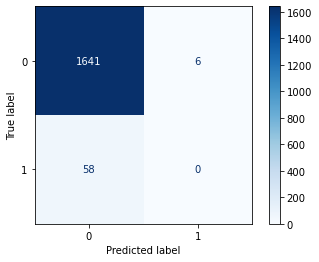

In [62]:
cf = confusion_matrix(y_test,y_hat_base)
plot_confusion_matrix(base,X_test,y_test,cmap=plt.cm.Blues)

In [63]:
scaler = StandardScaler()

# Transform the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

LogisticRegression(C=1000000000000.0, solver='liblinear')
[[1636   11]
 [  46   12]]
AUC: 0.9025500910746813
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1647
           1       0.52      0.21      0.30        58

    accuracy                           0.97      1705
   macro avg       0.75      0.60      0.64      1705
weighted avg       0.96      0.97      0.96      1705



C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


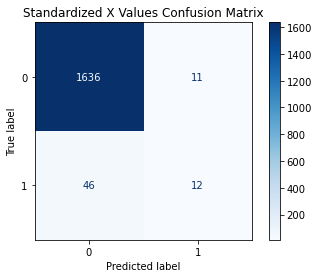

In [20]:
scaled = logreg.fit(X_train_scaled,y_train)
y_hat_scaled = scaled.predict(X_test_scaled)

print(scaled)

scaled_yscore =scaled.decision_function(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, scaled_yscore)
cf = confusion_matrix(y_test,y_hat_scaled)

plot_confusion_matrix(scaled,X_test_scaled,y_test,cmap=plt.cm.Blues)
plt.title("Standardized X Values Confusion Matrix")
print(cf)
print('AUC: {}'.format(auc(fpr, tpr)))
print(classification_report(y_test, y_hat_scaled))

<function sigmoid at 0x0000027077F96310>
AUC: 0.9218432678014363
[[1640    7]
 [  45   13]]
AUC: 0.9218432678014363
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1647
           1       0.65      0.22      0.33        58

    accuracy                           0.97      1705
   macro avg       0.81      0.61      0.66      1705
weighted avg       0.96      0.97      0.96      1705



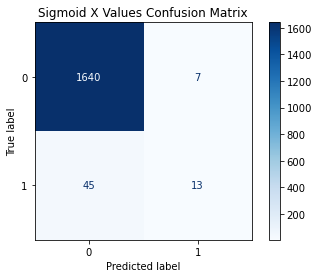

In [21]:
X_train_sig = X_train.apply(sigmoid)
X_train_sig = X_train_sig.dropna(axis=1)

X_test_sig = X_test.apply(sigmoid)
X_test_sig = X_test_sig.dropna(axis=1)

sig = logreg.fit(X_train_sig,y_train)
y_hat_sig = sig.predict(X_test_sig)
print(sigmoid)


sig_y_score = sig.decision_function(X_test_sig)

fpr, tpr, thresholds = roc_curve(y_test, sig_y_score)
print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_sig)

plot_confusion_matrix(sig,X_test_sig,y_test,cmap=plt.cm.Blues)
plt.title("Sigmoid X Values Confusion Matrix")
print(cf)
print('AUC: {}'.format(auc(fpr, tpr)))
print(classification_report(y_test, y_hat_sig))

In [22]:
df_major = df[df['Bankrupt?'] == 0]
df_minor = df[df['Bankrupt?'] == 1]

df_minor_up = resample(df_minor, replace=True,n_samples=440, random_state=42)
df_major_down = resample(df_major, replace=True,n_samples=3300, random_state=42)

updowndf = pd.concat([df_major_down,df_minor_up])

In [23]:
updowndf['Bankrupt?'].value_counts()

0    3300
1     440
Name: Bankrupt?, dtype: int64

In [24]:
X = df.drop(columns='Bankrupt?',axis=1)
y = df['Bankrupt?']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=.25)
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
train = pd.concat([y_train,X_train],axis=1)
train['Bankrupt?'].value_counts()

0    4952
1     162
Name: Bankrupt?, dtype: int64

In [25]:
train_major = train[train['Bankrupt?'] == 0]
train_minor = train[train['Bankrupt?'] == 1]

train_minor_up = resample(train_minor, replace=True,n_samples=324, random_state=42)
train_major_down = resample(train_major, replace=True,n_samples=2476, random_state=42)

updowndf = pd.concat([train_major_down,train_minor_up])

AUC: 0.9091346858446914
[[1593   54]
 [  27   31]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1647
           1       0.36      0.53      0.43        58

    accuracy                           0.95      1705
   macro avg       0.67      0.75      0.70      1705
weighted avg       0.96      0.95      0.96      1705



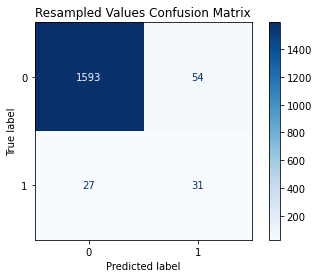

In [26]:
X_train_resampled = updowndf.drop(columns='Bankrupt?',axis=1).apply(sigmoid)
X_train_resampled = X_train_resampled.dropna(axis=1)
y_train_resampled = updowndf['Bankrupt?']
X_test_sig = X_test.apply(sigmoid)
X_test_sig = X_test_sig.dropna(axis=1)

resampled = logreg.fit(X_train_resampled,y_train_resampled)
y_pred_resampled = logreg.predict(X_test_sig)

resampled_y_score = resampled.decision_function(X_test_sig)

fpr, tpr, thresholds = roc_curve(y_test, resampled_y_score)
print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_resampled)

plot_confusion_matrix(resampled,X_test_sig,y_test,cmap=plt.cm.Blues)
plt.title("Resampled Values Confusion Matrix")

print(confusion_matrix(y_test, y_pred_resampled))
print(classification_report(y_test, y_pred_resampled))

In [27]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

In [108]:
dtree_default = DecisionTreeClassifier()
dtree_default.fit(X1_train, y_train)

print(confusion_matrix(y_test, dtree_default.predict(X1_test)))
print(classification_report(y_test, dtree_default.predict(X1_test)))

[[1595   58]
 [  38   14]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1653
           1       0.19      0.27      0.23        52

    accuracy                           0.94      1705
   macro avg       0.59      0.62      0.60      1705
weighted avg       0.95      0.94      0.95      1705



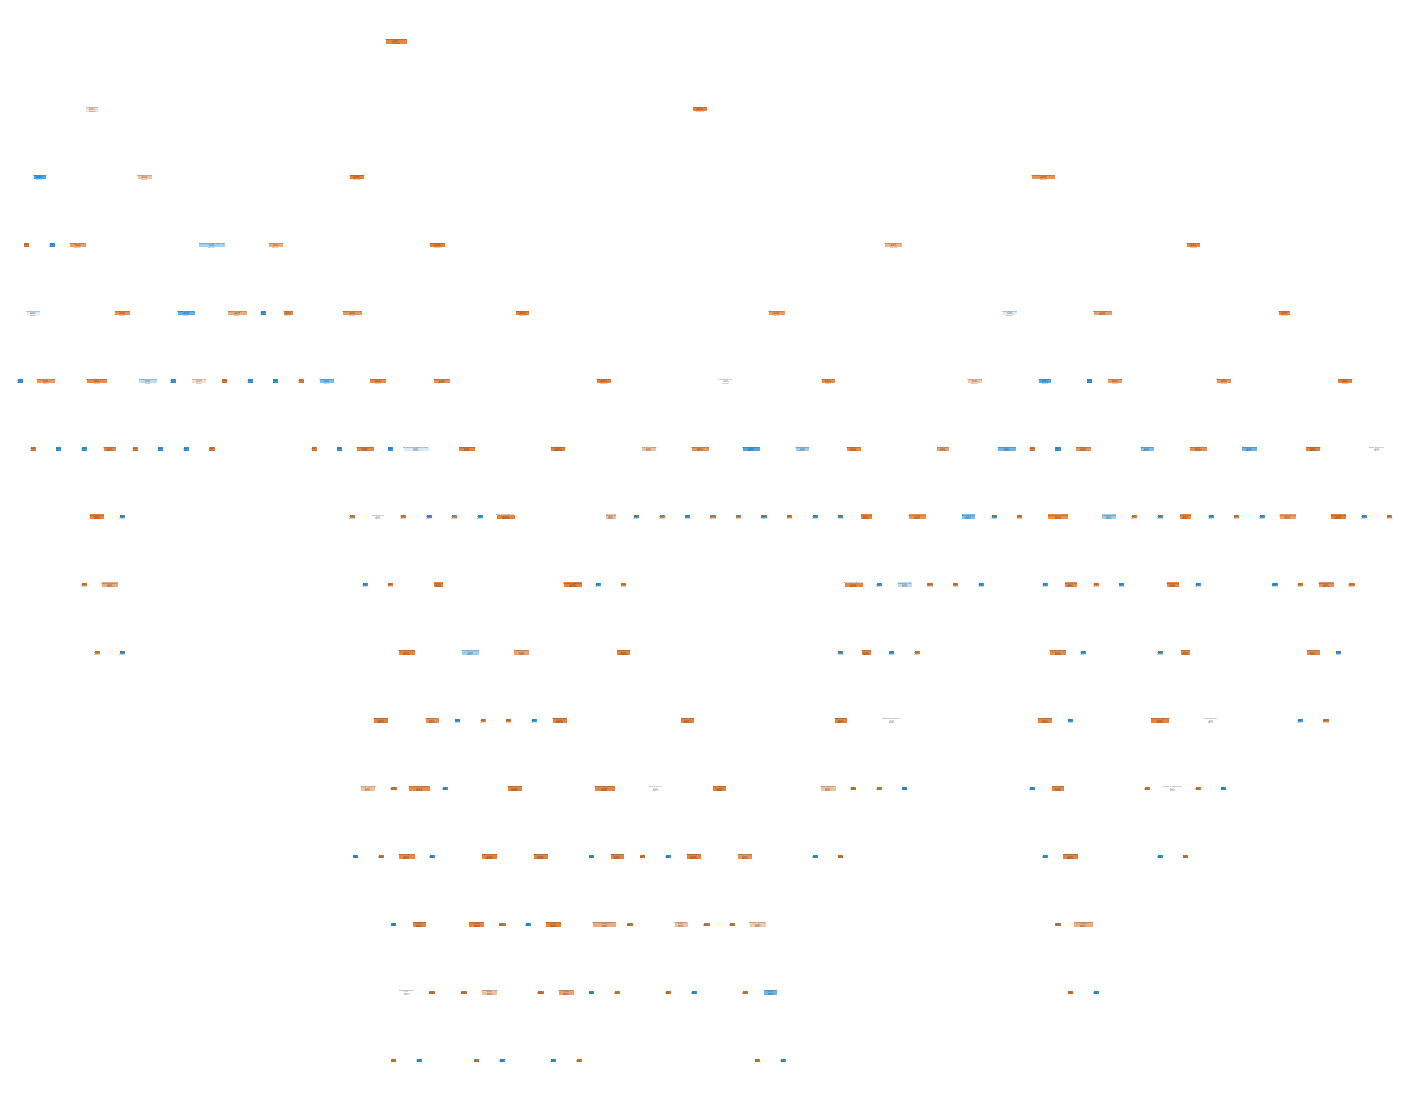

In [109]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dtree_default, 
                   feature_names=X.columns,
                   filled=True)


## Logreg Model with Oversampled Minority and Undersampled Majority

In [29]:
X = df.drop(columns='Bankrupt?',axis=1)
y = df['Bankrupt?']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=.25)
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
train = pd.concat([y_train,X_train],axis=1)
train['Bankrupt?'].value_counts()

0    4952
1     162
Name: Bankrupt?, dtype: int64

In [30]:
train_major = train[train['Bankrupt?'] == 0]
train_minor = train[train['Bankrupt?'] == 1]

train_minor_up = resample(train_minor, replace=True,n_samples=336, random_state=42)
train_major_down = resample(train_major, replace=True,n_samples=2473, random_state=42)

updowndf = pd.concat([train_major_down,train_minor_up])

In [31]:

X_train_resampled = updowndf.drop(columns='Bankrupt?',axis=1).apply(sigmoid)
X_train_resampled = X_train_resampled.dropna(axis=1)
y_train_resampled = updowndf['Bankrupt?']
X_test_sig = X_test.apply(sigmoid)
X_test_sig = X_test_sig.dropna(axis=1)

resampled = logreg.fit(X_train_resampled,y_train_resampled)
y_pred_test = logreg.predict(X_test_sig)


print(confusion_matrix(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

[[1589   58]
 [  26   32]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1647
           1       0.36      0.55      0.43        58

    accuracy                           0.95      1705
   macro avg       0.67      0.76      0.70      1705
weighted avg       0.96      0.95      0.96      1705



In [32]:
clf = KNeighborsClassifier()
KNN = clf.fit(X_train_resampled,y_train_resampled)
print(confusion_matrix(y_test, KNN.predict(X_test_sig)))
print(classification_report(y_test, KNN.predict(X_test_sig)))

[[1574   73]
 [  44   14]]
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1647
           1       0.16      0.24      0.19        58

    accuracy                           0.93      1705
   macro avg       0.57      0.60      0.58      1705
weighted avg       0.95      0.93      0.94      1705



In [33]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_smote).value_counts()) 

Original class distribution: 

0    6599
1     220
Name: Bankrupt?, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    4952
0    4952
Name: Bankrupt?, dtype: int64


## Running Smote on Base X and Y without resampling

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')
AUC: 0.9029478885329649
[[1498  149]
 [  17   41]]
              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1647
           1       0.22      0.71      0.33        58

    accuracy                           0.90      1705
   macro avg       0.60      0.81      0.64      1705
weighted avg       0.96      0.90      0.93      1705



C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


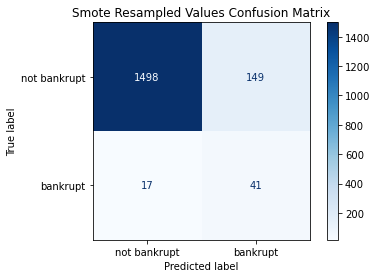

In [34]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 
X_train_smote_sig = X_train_smote.apply(sigmoid)
X_train_smote_sig = X_train_smote_sig.dropna(axis=1)
smote_model = logreg.fit(X_train_smote_sig, y_train_smote)
print(smote_model)

# Predict
y_hat_smote = logreg.predict(X_test_sig)

y_score_smote = logreg.decision_function(X_test_sig)

fpr, tpr, thresholds = roc_curve(y_test, y_score_smote)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_smote)

plot_confusion_matrix(smote_model,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("Smote Resampled Values Confusion Matrix")

print(confusion_matrix(y_test, y_hat_smote))
print(classification_report(y_test, y_hat_smote))

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

LogisticRegression(C=1e+20, fit_intercept=False)
0.1               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1647
           1       0.50      0.41      0.45        58

    accuracy                           0.97      1705
   macro avg       0.74      0.70      0.72      1705
weighted avg       0.96      0.97      0.96      1705

0.1 [[1623   24]
 [  34   24]]
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
0.25               precision    recall  f1-score   support

           0       0.99      0.96      0.97      1647
           1       0.36      0.66      0.46        58

    accuracy                           0.95      1705
   macro avg       0.67      0.81      0.72      1705
weighted avg       0.97      0.95      0.96      1705

0.25

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

 [[1579   68]
 [  20   38]]
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
0.33               precision    recall  f1-score   support

           0       0.99      0.95      0.97      1647
           1       0.32      0.66      0.43        58

    accuracy                           0.94      1705
   macro avg       0.65      0.80      0.70      1705
weighted avg       0.96      0.94      0.95      1705

0.33 [[1566   81]
 [  20   38]]
-------------------------------------------------------------------------------------
LogisticRegression(C=1e+20, fit_intercept=False)
0.5               precision    recall  f1-score   support

           0       0.99      0.93      0.96      1647
           1       0.29      0.76      0.42        58

    accuracy                           0.93      1705
   macro avg       0.64      0.85      0.69      1705
weighted avg       0.97      0.93      0.94      1705

0.5 [[1

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1e+20, fit_intercept=False)
0.7               precision    recall  f1-score   support

           0       0.99      0.90      0.95      1647
           1       0.22      0.78      0.34        58

    accuracy                           0.90      1705
   macro avg       0.61      0.84      0.65      1705
weighted avg       0.97      0.90      0.93      1705

0.7 [[1489  158]
 [  13   45]]
-------------------------------------------------------------------------------------


C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1e+20, fit_intercept=False)
even               precision    recall  f1-score   support

           0       0.99      0.90      0.94      1647
           1       0.21      0.78      0.33        58

    accuracy                           0.89      1705
   macro avg       0.60      0.84      0.64      1705
weighted avg       0.96      0.89      0.92      1705

even [[1480  167]
 [  13   45]]
-------------------------------------------------------------------------------------


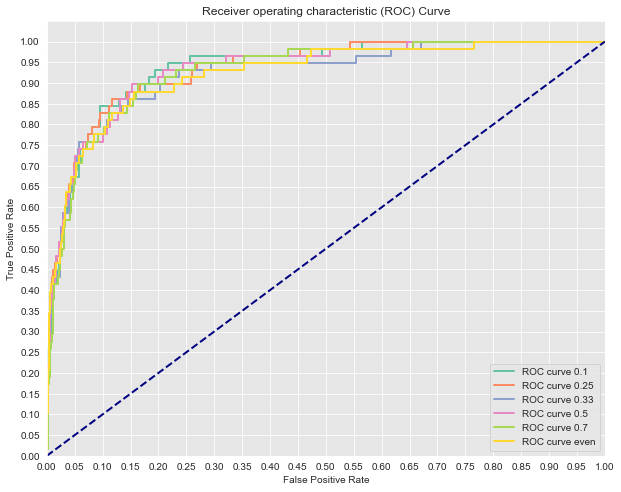

In [62]:
# Now let's compare a few different ratios of minority class to majority class
ratios = [0.1, 0.25, 0.33, 0.5, 0.7, 1]
names = ['0.1', '0.25', '0.33','0.5','0.7','even']
colors = sns.color_palette('Set2')

plt.figure(figsize=(10, 8))

for n, ratio in enumerate(ratios):
    # Fit a model
    smote = SMOTE(sampling_strategy=ratio)
    X_train_smote, y_train_smote = smote.fit_sample(X_train,y_train) 
    X_train_smote_sig = X_train_smote.apply(sigmoid)
    X_train_smote_sig.dropna(axis=1)
    logreg = LogisticRegression(fit_intercept=False, C=1e20, solver ='lbfgs')
    model_log = logreg.fit(X_train_smote_sig, y_train_smote)
    print(model_log)

    # Predict
    y_hat_test = logreg.predict(X_test_sig)

    y_score = logreg.decision_function(X_test_sig)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    print(names[n],classification_report(y_test, y_hat_test))
    print(names[n], confusion_matrix(y_test, y_hat_test))
    print('-------------------------------------------------------------------------------------')
    
    lw = 2
    plt.plot(fpr, tpr, color=colors[n],
             lw=lw, label='ROC curve {}'.format(names[n]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

## Random Forest baseline no scaling

In [36]:
forest = RandomForestClassifier(random_state=42)
forest_cv_score = cross_val_score(forest,X_train, y_train, cv=5)
mean_forest_cv_score = np.mean(forest_cv_score)
print(f"Mean Cross Validation Score: {mean_forest_cv_score :.2%}")


Mean Cross Validation Score: 96.91%


[[1643    4]
 [  45   13]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1647
           1       0.76      0.22      0.35        58

    accuracy                           0.97      1705
   macro avg       0.87      0.61      0.67      1705
weighted avg       0.97      0.97      0.96      1705



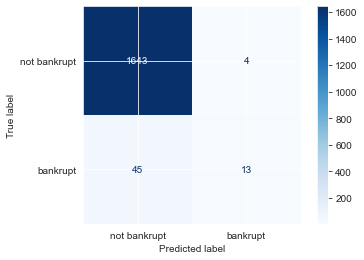

In [71]:
forest_base = forest.fit(X_train,y_train)
y_hat_forest_base = forest.predict(X_test)

print(confusion_matrix(y_test, y_hat_forest_base))
print(classification_report(y_test, y_hat_forest_base))
plot_confusion_matrix(forest_base,X_test,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")

## RF standard scaling

In [78]:
scaled_forest = forest.fit(X_train_scaled,y_train)
forest_cv_score = cross_val_score(scaled_forest,X_train_scaled, y_train, cv=5)
mean_forest_cv_score = np.mean(forest_cv_score)
print(f"Mean Cross Validation Score: {mean_forest_cv_score :.2%}")


Mean Cross Validation Score: 96.77%


[[1644    3]
 [  49    9]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1647
           1       0.75      0.16      0.26        58

    accuracy                           0.97      1705
   macro avg       0.86      0.58      0.62      1705
weighted avg       0.96      0.97      0.96      1705



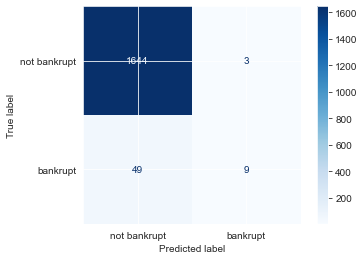

In [79]:
scaled_forest = forest.fit(X_train_scaled,y_train)
y_hat_forest_scaled = forest.predict(X_test_scaled)

print(confusion_matrix(y_test, y_hat_forest_scaled))
print(classification_report(y_test, y_hat_forest_scaled))
plot_confusion_matrix(scaled_forest,X_test_scaled,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")

## RF Sigmoid Scaled

In [89]:
forest_sig = RandomForestClassifier(random_state=42)
forest_sig = forest_sig.fit(X_train_sig,y_train)
forest_cv_score = cross_val_score(forest_sig,X_train_sig, y_train, cv=5)
mean_forest_cv_score = np.mean(forest_cv_score)
print(f"Mean Cross Validation Score: {mean_forest_cv_score :.2%}")


Mean Cross Validation Score: 96.89%


[[1646    1]
 [  46   12]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      1647
           1       0.92      0.21      0.34        58

    accuracy                           0.97      1705
   macro avg       0.95      0.60      0.66      1705
weighted avg       0.97      0.97      0.96      1705



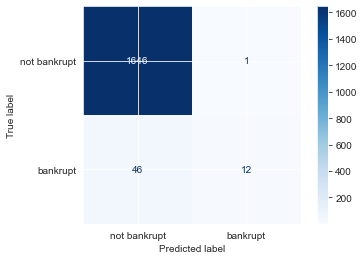

In [90]:
y_hat_forest_sig = forest_sig.predict(X_test_sig)

print(confusion_matrix(y_test, y_hat_forest_sig))
print(classification_report(y_test, y_hat_forest_sig))
plot_confusion_matrix(forest_sig,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")

In [ ]:
## sigmoid scaled model is marginally better for both true precision and recall

## RF w Smote

In [94]:
forest_smote = RandomForestClassifier(random_state=42)
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 
X_train_smote_sig = X_train_smote.apply(sigmoid)
X_train_smote_sig = X_train_smote_sig.dropna(axis=1)



forest_smote= forest_smote.fit(X_train_smote_sig,y_train_smote)
forest_cv_score = cross_val_score(forest_smote,X_train_smote_sig, y_train_smote, cv=5)
mean_forest_cv_score = np.mean(forest_cv_score)
print(f"Mean Cross Validation Score: {mean_forest_cv_score :.2%}")


Mean Cross Validation Score: 97.92%


[[1599   48]
 [  26   32]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1647
           1       0.40      0.55      0.46        58

    accuracy                           0.96      1705
   macro avg       0.69      0.76      0.72      1705
weighted avg       0.96      0.96      0.96      1705



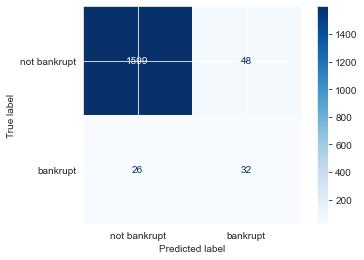

In [95]:
y_hat_forest_smote = forest_smote.predict(X_test_sig)

print(confusion_matrix(y_test, y_hat_forest_smote))
print(classification_report(y_test, y_hat_forest_smote))
plot_confusion_matrix(forest_smote,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")

## RF with Smote standard scaled

In [ ]:
X

In [38]:
X_train_smote_stan_scal = scaler.fit_transform(X_train_smote)

In [371]:
forest_smote = RandomForestClassifier(random_state=42)
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 
X_train_smote_stan_scal = scaler.fit_transform(X_train_smote)




forest_smote= forest_smote.fit(X_train_smote_stan_scal,y_train_smote)
forest_cv_score = cross_val_score(forest_smote,X_train_smote_stan_scal, y_train_smote, cv=5)
mean_forest_cv_score = np.mean(forest_cv_score)
print(f"Mean Cross Validation Score: {mean_forest_cv_score :.2%}")


Mean Cross Validation Score: 97.93%


[[1588   59]
 [  27   31]]
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1647
           1       0.34      0.53      0.42        58

    accuracy                           0.95      1705
   macro avg       0.66      0.75      0.70      1705
weighted avg       0.96      0.95      0.95      1705



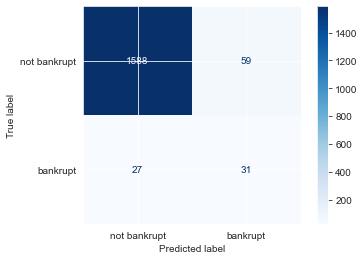

In [372]:
y_hat_forest_smote = forest_smote.predict(X_test_scaled)

print(confusion_matrix(y_test, y_hat_forest_smote))
print(classification_report(y_test, y_hat_forest_smote))
plot_confusion_matrix(forest_smote,X_test_scaled,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")

In [ ]:
a

In [98]:
forest_param_grid = {'criterion': ['gini','entropy'],
    'max_depth' : [8,12,16],
    'min_samples_leaf' : [2, 4, 5, 7],
    'min_samples_split' : [2, 4, 5, 6, 7, 9],
}
forest =RandomForestClassifier(random_state=42)
forest_grid = GridSearchCV(estimator=forest,param_grid=forest_param_grid,scoring='recall')

In [99]:
forest_grid.fit(X_train_smote_sig,y_train_smote)

GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [8, 12, 16],
                         'min_samples_leaf': [2, 4, 5, 7],
                         'min_samples_split': [2, 4, 5, 6, 7, 9]},
             scoring='recall')

In [100]:
forest_grid.best_params_

{'criterion': 'entropy',
 'max_depth': 16,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [101]:
forest_grid.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=16, min_samples_leaf=2,
                       random_state=42)

In [104]:
forest_best = RandomForestClassifier(criterion="entropy", max_depth=16, min_samples_leaf=2, min_samples_split=2)

[[1588   59]
 [  20   38]]
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1647
           1       0.39      0.66      0.49        58

    accuracy                           0.95      1705
   macro avg       0.69      0.81      0.73      1705
weighted avg       0.97      0.95      0.96      1705



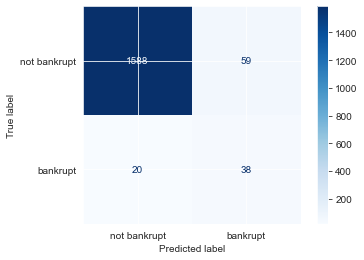

In [113]:
forest_best.fit(X_train_smote_sig,y_train_smote)
forest_best.predict(X_test_sig)

y_pred_forest_best = forest_best.predict(X_test_sig)
print(confusion_matrix(y_test, y_pred_forest_best))
print(classification_report(y_test, y_pred_forest_best))
plot_confusion_matrix(forest_best,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")

In [232]:
fig = plt.figure(figsize=(25,20))
_ = plot_forest(forest_grid.best_estimator_, 
                   feature_names=X.columns,
                   filled=True)

NameError: name 'plot_forest' is not defined

<Figure size 1800x1440 with 0 Axes>

In [273]:
log_param_grid = {'penalty': ['l1','l2'],
    'solver' : ['liblinear','saga'],
    'fit_intercept' : [True,False],
    'C' : [0.001,0.1,1,100,10000,1000000,1000000000,100000000000,],
}
log =LogisticRegression(random_state=42)
log_grid = GridSearchCV(estimator=log,param_grid=log_param_grid,scoring='recall')


In [274]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 
X_train_smote_stan_scal = scaler.fit_transform(X_train_smote)

In [275]:
len(X_train_smote_stan_scal),len(y_train_smote)

(9904, 9904)

In [276]:
log_grid.fit(X_train_smote_sig,y_train_smote)

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: 

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sa

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: Con

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: 

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.p

C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_sa

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': [0.001, 0.1, 1, 100, 10000, 1000000, 1000000000,
                               100000000000],
                         'fit_intercept': [True, False],
                         'penalty': ['l1', 'l2'],
                         'solver': ['liblinear', 'saga']},
             scoring='recall')

In [277]:
log_grid.best_params_

{'C': 100000000000,
 'fit_intercept': True,
 'penalty': 'l2',
 'solver': 'liblinear'}

In [278]:
log_grid.cv_results_['mean']

{'mean_fit_time': array([3.02140236e-02, 2.27347374e-02, 4.60528851e-02, 1.31857920e-01,
        2.65359402e-02, 2.18698978e-02, 3.99869442e-02, 1.31502151e-01,
        7.45925107e+00, 8.34959841e-01, 7.18837738e-02, 1.20003366e-01,
        8.19937472e+00, 8.22843409e-01, 6.82873726e-02, 1.22397757e-01,
        1.69313644e+01, 8.63760996e-01, 1.20870972e-01, 6.13922787e-01,
        1.84950154e+01, 8.73055029e-01, 1.18543911e-01, 5.47483826e-01,
        5.42192980e+01, 1.08982944e+00, 3.09375095e-01, 6.17930269e-01,
        5.46389965e+01, 1.07304573e+00, 3.34042025e-01, 6.15921831e-01,
        6.30747563e+01, 1.11903038e+00, 2.60969172e+00, 6.20132303e-01,
        6.65784155e+01, 1.13096476e+00, 2.24127278e+00, 6.14920187e-01,
        6.44076238e+01, 1.12090559e+00, 3.67965665e+00, 6.15156603e-01,
        6.59916940e+01, 1.11021609e+00, 3.78714614e+00, 6.14555979e-01,
        6.47174643e+01, 1.11756973e+00, 3.75441308e+00, 6.17300940e-01,
        6.60580731e+01, 1.11031027e+00, 4.10774

In [46]:
X = df2.drop(columns='Bankrupt?',axis=1)
y = df2['Bankrupt?']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42,test_size=.25)
logreg = LogisticRegression(fit_intercept=True, C=1e12, solver='liblinear')

In [47]:
X_test_scaled = scaler.transform(X_test)

ValueError: X has 76 features, but this StandardScaler is expecting 95 features as input.

LogisticRegression(C=100000000000.0, random_state=42, solver='liblinear')
AUC: 0.9007809392207358
[[723 924]
 [  2  56]]
              precision    recall  f1-score   support

           0       1.00      0.44      0.61      1647
           1       0.06      0.97      0.11        58

    accuracy                           0.46      1705
   macro avg       0.53      0.70      0.36      1705
weighted avg       0.97      0.46      0.59      1705



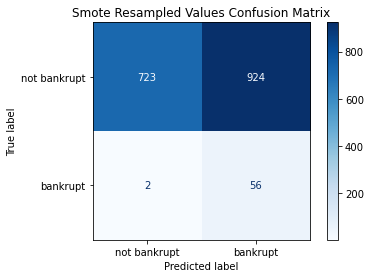

In [69]:
log_best = LogisticRegression(C=1e11,fit_intercept=True,solver='liblinear')
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 
X_train_smote_stan_scal = scaler.fit_transform(X_train_smote)
smote_model = log_best.fit(X_train_smote_stan_scal, y_train_smote)
print(smote_model)

# Predict
y_hat_smote = log_best.predict(X_test_scaled)

y_score_smote = log_best.decision_function(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_score_smote)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_smote)

plot_confusion_matrix(smote_model,X_test_scaled,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("Smote Resampled Values Confusion Matrix")

print(confusion_matrix(y_test, y_hat_smote))
print(classification_report(y_test, y_hat_smote))

LogisticRegression(C=1000000000000.0, solver='liblinear')
AUC: 0.9086007997822582
[[1486  161]
 [  14   44]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      1647
           1       0.21      0.76      0.33        58

    accuracy                           0.90      1705
   macro avg       0.60      0.83      0.64      1705
weighted avg       0.96      0.90      0.92      1705



C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


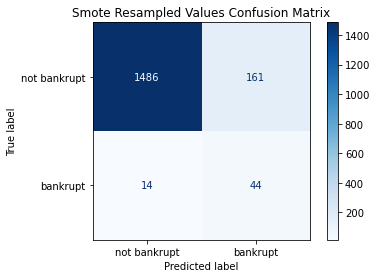

In [68]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train) 
X_train_smote_sig = X_train_smote.apply(sigmoid)
X_train_smote_sig = X_train_smote_sig.dropna(axis=1)
X_test_sig = X_test.apply(sigmoid)
X_test_sig = X_test_sig.dropna(axis=1)
smote_model = logreg.fit(X_train_smote_sig, y_train_smote)
print(smote_model)

# Predict
y_hat_smote = logreg.predict(X_test_sig)

y_score_smote = logreg.decision_function(X_test_sig)

fpr, tpr, thresholds = roc_curve(y_test, y_score_smote)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_hat_smote)

plot_confusion_matrix(smote_model,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("Smote Resampled Values Confusion Matrix")

print(confusion_matrix(y_test, y_hat_smote))
print(classification_report(y_test, y_hat_smote))

## KNN 

In [70]:
df2

,Bankrupt?,ROA(C) before interest and depreciation before interest,operating gross margin,operating profit rate,non-industry income and expenditure/revenue,operating expense rate,research and development expense rate,cash flow rate,interest-bearing debt interest rate,tax rate (A),...,current liabilities to current assets,one if total liabilities exceeds total assets zero otherwise,net income to total assets,total assets to GNP price,No-credit interval,Net income to stockholder's Equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
0,1,0.370594,0.601457,0.998969,0.302646,1.256970e-04,0.000000e+00,0.458143,7.250730e-04,0.000000,...,0.118250,0,0.716845,0.009219,0.622879,0.827890,0.026601,0.564050,1,0.016469
1,1,0.464291,0.610235,0.998946,0.303556,2.897850e-04,0.000000e+00,0.461867,6.470650e-04,0.000000,...,0.047775,0,0.795297,0.008323,0.623652,0.839969,0.264577,0.570175,1,0.020794
2,1,0.426071,0.601450,0.998857,0.302035,2.361300e-04,2.550000e+07,0.458521,7.900790e-04,0.000000,...,0.025346,0,0.774670,0.040003,0.623841,0.836774,0.026555,0.563706,1,0.016474
3,1,0.399844,0.583541,0.998700,0.303350,1.078890e-04,0.000000e+00,0.465705,4.490450e-04,0.000000,...,0.067250,0,0.739555,0.003252,0.622929,0.834697,0.026697,0.564663,1,0.023982
4,1,0.465022,0.598783,0.998973,0.303475,7.890000e+09,0.000000e+00,0.462746,6.860690e-04,0.000000,...,0.047725,0,0.795016,0.003878,0.623521,0.839973,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.604455,0.998992,0.303510,1.510210e-04,4.500000e+09,0.463734,1.790180e-04,0.113372,...,0.027951,0,0.799927,0.000466,0.623620,0.840359,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.598308,0.998992,0.303520,5.220000e+09,1.440000e+09,0.461978,2.370240e-04,0.371596,...,0.031470,0,0.799748,0.001959,0.623931,0.840306,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.610444,0.998984,0.303512,2.509310e-04,1.039090e-04,0.472189,0.000000e+00,0.490839,...,0.007542,0,0.797778,0.002840,0.624156,0.840138,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.607850,0.999074,0.303498,1.236150e-04,2.510000e+09,0.476123,2.110210e-04,0.181294,...,0.022916,0,0.811808,0.002837,0.623957,0.841084,0.026822,0.565302,1,0.044009


AUC: 0.835165295312271
[[1388  259]
 [  10   48]]
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      1647
           1       0.16      0.83      0.26        58

    accuracy                           0.84      1705
   macro avg       0.57      0.84      0.59      1705
weighted avg       0.96      0.84      0.89      1705



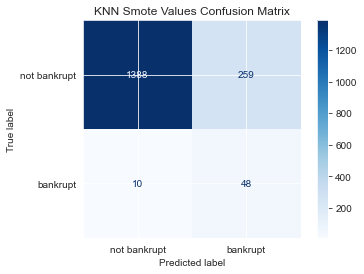

In [369]:
knn = KNeighborsClassifier(n_neighbors=13,)
knn.fit(X_train_smote_sig,y_train_smote)


y_pred_knn = knn.predict(X_test_sig)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_knn)

plot_confusion_matrix(knn,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("KNN Smote Values Confusion Matrix")

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))



In [ ]:
knn

In [ ]:
## sacrificing precision in order to prioritize recall as is more valid metric of the twoaa

In [316]:
find_best_k_recall(X_train_smote_sig, y_train_smote,X_test_sig,y_test)

Best Value for k: 13
Recall-Score: 0.8275862068965517


In [319]:
find_best_k(X_train_smote_sig, y_train_smote,X_test_sig,y_test)

Best Value for k: 1
F1-Score: 0.30985915492957744


AUC: 0.835165295312271
[[1388  259]
 [  10   48]]
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      1647
           1       0.16      0.83      0.26        58

    accuracy                           0.84      1705
   macro avg       0.57      0.84      0.59      1705
weighted avg       0.96      0.84      0.89      1705



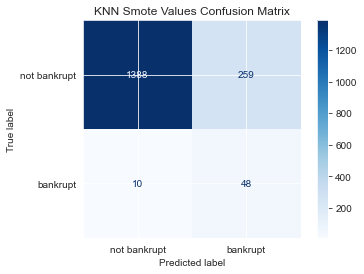

In [374]:
knn = KNeighborsClassifier(n_neighbors=13,p=2)
knn.fit(X_train_smote_sig,y_train_smote)


y_pred_knn = knn.predict(X_test_sig)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_knn)

plot_confusion_matrix(knn,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("KNN Smote Values Confusion Matrix")

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


AUC: 0.7946789355777485
[[1567   80]
 [  21   37]]
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1647
           1       0.32      0.64      0.42        58

    accuracy                           0.94      1705
   macro avg       0.65      0.79      0.70      1705
weighted avg       0.96      0.94      0.95      1705



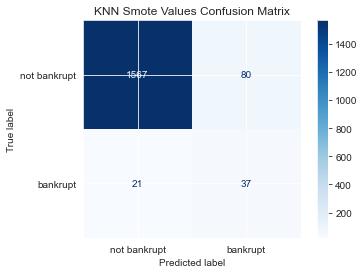

In [379]:
knn = KNeighborsClassifier(n_neighbors=1,p=1)
knn.fit(X_train_smote_stan_scal,y_train_smote)


y_pred_knn = knn.predict(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_knn)

plot_confusion_matrix(knn,X_test_scaled,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("KNN Smote Values Confusion Matrix")

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

In [331]:
find_best_k(X_train_smote_stan_scal,y_train_smote,X_test_scaled,y_test)

Best Value for k: 1
F1-Score: 0.3422459893048128


In [332]:
find_best_k_recall(X_train_smote_stan_scal,y_train_smote,X_test_scaled,y_test)

Best Value for k: 13
Recall-Score: 0.8448275862068966


AUC: 0.8312815359169231
[[1432  215]
 [  12   46]]
              precision    recall  f1-score   support

           0       0.99      0.87      0.93      1647
           1       0.18      0.79      0.29        58

    accuracy                           0.87      1705
   macro avg       0.58      0.83      0.61      1705
weighted avg       0.96      0.87      0.90      1705



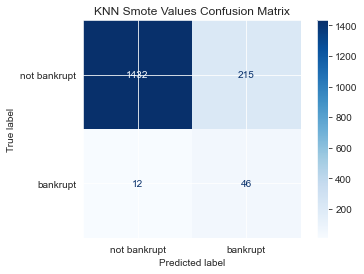

In [376]:
knn = KNeighborsClassifier(n_neighbors=13,p=1)
knn.fit(X_train_smote_stan_scal,y_train_smote)


y_pred_knn = knn.predict(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_knn)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_knn)

plot_confusion_matrix(knn,X_test_scaled,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("KNN Smote Values Confusion Matrix")

print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))

In [345]:
knn_param_grid = {'p': [1,2],
                  'weights' : ['uniform','distance'],
                  'n_neighbors': [1,5,13,17,25]
}
knn =KNeighborsClassifier()
knn_grid = GridSearchCV(estimator=knn,param_grid=knn_param_grid,scoring='recall',verbose=2,return_train_score=True)


In [346]:
knn_grid.fit(X_train_smote_sig,y_train_smote)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_neighbors=1, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. n_neighbors=1, p=1, weights=uniform, total=   0.7s
[CV] n_neighbors=1, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] .............. n_neighbors=1, p=1, weights=uniform, total=   0.6s
[CV] n_neighbors=1, p=1, weights=uniform .............................
[CV] .............. n_neighbors=1, p=1, weights=uniform, total=   0.6s
[CV] n_neighbors=1, p=1, weights=uniform .............................
[CV] .............. n_neighbors=1, p=1, weights=uniform, total=   0.7s
[CV] n_neighbors=1, p=1, weights=uniform .............................
[CV] .............. n_neighbors=1, p=1, weights=uniform, total=   0.6s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   0.6s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   0.6s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   0.6s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] .

[CV] ............ n_neighbors=13, p=2, weights=distance, total=   1.0s
[CV] n_neighbors=17, p=1, weights=uniform ............................
[CV] ............. n_neighbors=17, p=1, weights=uniform, total=   0.9s
[CV] n_neighbors=17, p=1, weights=uniform ............................
[CV] ............. n_neighbors=17, p=1, weights=uniform, total=   0.8s
[CV] n_neighbors=17, p=1, weights=uniform ............................
[CV] ............. n_neighbors=17, p=1, weights=uniform, total=   0.9s
[CV] n_neighbors=17, p=1, weights=uniform ............................
[CV] ............. n_neighbors=17, p=1, weights=uniform, total=   0.9s
[CV] n_neighbors=17, p=1, weights=uniform ............................
[CV] ............. n_neighbors=17, p=1, weights=uniform, total=   0.9s
[CV] n_neighbors=17, p=1, weights=distance ...........................
[CV] ............ n_neighbors=17, p=1, weights=distance, total=   0.9s
[CV] n_neighbors=17, p=1, weights=distance ...........................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  5.9min finished


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 13, 17, 25], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='recall', verbose=2)

In [350]:
## results for KNN grid for X_train_smote_sig
np.mean(knn_grid.cv_results_['mean_train_score'])

0.9898147205317469

In [351]:
knn_grid_scaled = GridSearchCV(estimator=knn,param_grid=knn_param_grid,scoring='recall',verbose=2,return_train_score=True)
knn_grid_scaled.fit(X_train_smote_stan_scal,y_train_smote)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] n_neighbors=1, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............. n_neighbors=1, p=1, weights=uniform, total=   1.0s
[CV] n_neighbors=1, p=1, weights=uniform .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] .............. n_neighbors=1, p=1, weights=uniform, total=   1.0s
[CV] n_neighbors=1, p=1, weights=uniform .............................
[CV] .............. n_neighbors=1, p=1, weights=uniform, total=   1.0s
[CV] n_neighbors=1, p=1, weights=uniform .............................
[CV] .............. n_neighbors=1, p=1, weights=uniform, total=   1.0s
[CV] n_neighbors=1, p=1, weights=uniform .............................
[CV] .............. n_neighbors=1, p=1, weights=uniform, total=   1.0s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   0.9s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   0.9s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] ............. n_neighbors=1, p=1, weights=distance, total=   1.0s
[CV] n_neighbors=1, p=1, weights=distance ............................
[CV] .

[CV] ............ n_neighbors=13, p=2, weights=distance, total=   1.8s
[CV] n_neighbors=17, p=1, weights=uniform ............................
[CV] ............. n_neighbors=17, p=1, weights=uniform, total=   1.6s
[CV] n_neighbors=17, p=1, weights=uniform ............................
[CV] ............. n_neighbors=17, p=1, weights=uniform, total=   1.5s
[CV] n_neighbors=17, p=1, weights=uniform ............................
[CV] ............. n_neighbors=17, p=1, weights=uniform, total=   1.5s
[CV] n_neighbors=17, p=1, weights=uniform ............................
[CV] ............. n_neighbors=17, p=1, weights=uniform, total=   1.5s
[CV] n_neighbors=17, p=1, weights=uniform ............................
[CV] ............. n_neighbors=17, p=1, weights=uniform, total=   1.5s
[CV] n_neighbors=17, p=1, weights=distance ...........................
[CV] ............ n_neighbors=17, p=1, weights=distance, total=   1.4s
[CV] n_neighbors=17, p=1, weights=distance ...........................
[CV] .

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 10.1min finished


GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 5, 13, 17, 25], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             return_train_score=True, scoring='recall', verbose=2)

In [352]:
knn_grid_scaled.best_params_

{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}

In [308]:
def find_best_k_recall(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        recall = recall_score(y_test, preds)
        if recall > best_score:
            best_k = k
            best_score = recall
    
    print("Best Value for k: {}".format(best_k))
    print("Recall-Score: {}".format(best_score))

hard to say whether standard scaled or sigmoid scaled is better but both are best in regards to to classifying bankrupt companies with n_neighbors as 13 and p=1 so this will be model to use for final

## Gradient Boosting

In [64]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
grad_clf = GradientBoostingClassifier()

In [67]:
grad_clf.fit(X_train_smote_sig,y_train_smote)

y_pred_grad = grad_clf.predict(X_test_sig)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_grad)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_grad)

plot_confusion_matrix(grad_clf,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("KNN Smote Values Confusion Matrix")

print(confusion_matrix(y_test, y_pred_grad))
print(classification_report(y_test, y_pred_grad))


ValueError: Found input variables with inconsistent numbers of samples: [4946, 9904]

In [43]:
grad_clf.fit(X_train_smote_stan_scal,y_train_smote)

y_pred_grad = grad_clf.predict(X_test_scaled)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_grad)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_grad)

plot_confusion_matrix(grad_clf,X_test_scaled,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("KNN Smote Values Confusion Matrix")

print(confusion_matrix(y_test, y_pred_grad))
print(classification_report(y_test, y_pred_grad))

ValueError: Number of features of the model must match the input. Model n_features is 95 and input n_features is 76 

## Adaboost

In [39]:
ada_clf = AdaBoostClassifier()


### Adaboost with Sig

In [40]:
ada_clf.fit(X_train_smote_sig,y_train_smote)

AdaBoostClassifier()

AUC: 0.5
[[1647    0]
 [  58    0]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1647
           1       0.00      0.00      0.00        58

    accuracy                           0.97      1705
   macro avg       0.48      0.50      0.49      1705
weighted avg       0.93      0.97      0.95      1705



C:\Users\sergi\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


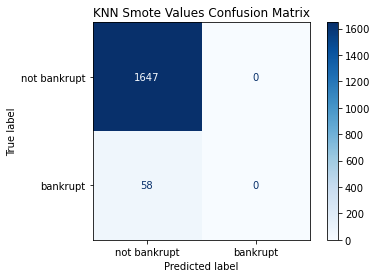

In [42]:

y_pred_ada = ada_clf.predict(X_test_sig)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_ada)

print('AUC: {}'.format(auc(fpr, tpr)))
cf = confusion_matrix(y_test,y_pred_ada)

plot_confusion_matrix(ada_clf,X_test_sig,y_test,cmap=plt.cm.Blues,
                     display_labels=["not bankrupt", "bankrupt"],
                      values_format=".5g")
plt.title("KNN Smote Values Confusion Matrix")

print(confusion_matrix(y_test, y_pred_ada))
print(classification_report(y_test, y_pred_ada))